In [2]:
import numpy as np
import matplotlib.pylab as plt
import sys
import os
import rosbag
import cv2
sys.path.append('/home/koji/dvs/vlc/src')
from detector import get_event_list_from_bag, estimate_led_positions_kmeans
from encoder import encoder

In [4]:
# rosbagpath = '../../vlc/data/vlc_slow_100_100hz_111100_110011.bag'
rosbagpath = '../data/localization_02.bag'
t_at = 0.5
freq = 100
n_led = 2
thres_detect_led = 100
event_list, event_time_list = get_event_list_from_bag(rosbag.Bag(rosbagpath), t_at)

IOError: [Errno 2] No such file or directory: '../data/localization_02.bag'

In [37]:
color = {
    '0': 'red',
    '1': 'green',
    'others': 'white'
}
id2msg = {
    '0': [True, True, False, False, True, True],
    '1': [True, True, True, True, False, False]
}

Detected the correct msg
Detected the correct msg
pos:[426, 118], msg:[True, True, True, True, False, False]
pos:[387, 308], msg:[True, True, False, False, True, True]


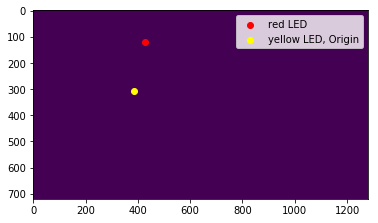

In [38]:
estimated_pos_dict, evidence_map_dict = estimate_led_positions_kmeans(
    event_list, 
    freq, 
    n_led=n_led,
    t_at=t_at,
    event_time_list=event_time_list, 
    n_tol=1, 
    sigma=30
)

encoded_msgs = encoder(event_list, estimated_pos_dict, freq, thres_detect_led, t_begin=0.0, t_end=t_at)
plt.imshow(np.zeros((720, 1280)))

ps = np.zeros((2, 2))

for key in encoded_msgs.keys():
    pos = estimated_pos_dict[key]
    msg = encoded_msgs[key]
    print('pos:{0}, msg:{1}'.format([int(pos[0]), int(pos[1])], msg))
    if msg == [True, True, False, False, True, True]:
        clr = 'yellow'
        label = 'yellow LED, Origin'
        ps[1] = pos
    elif msg == [True, True, True, True, False, False]:
        clr = 'red'
        label = 'red LED'
        ps[0] = pos
    else:
        clr = 'white'
        label = 'invalid'
    plt.scatter(pos[0], pos[1], color=clr, label=label)
plt.legend()

In [64]:
np.rad2deg(np.arctan2(3, 27))

6.34019174590991

In [52]:
def localize(ps, Pws, K, dist, method='xyz'):
    """
    Parameters:
    ------
    ps: numpy.array (shape: [n, 2])
        2D positions of markers in pixel
    Pws: 
        3D positions of markers in world frame
    K:
        calibration matrix
    dist:
        distortion parameters
    method:
        [x, xyz, xyyaw]
    """
    R_test = np.array([
        [0.0, 1.0, 0.0],
        [1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0]
    ])
    R = np.zeros((3, 3))
    T = np.zeros((3, 1))
    ps_undistort = cv2.undistortPoints(np.array([ps]).astype('float32'), K, dist, P=K)[0]
    ps_undistort
    Kinv = np.linalg.inv(K)
    if method=='xyz':
        u1 = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
        u2 = np.hstack([ps_undistort[1], 1]).reshape([-1, 1])
        A = np.block([[np.eye(3), -np.dot(Kinv, u1), np.zeros((3, 1))], [np.eye(3), np.zeros((3, 1)), -np.dot(Kinv, u2)]])
        b = - Pws.reshape([-1, 1])
        return np.eye(3), np.dot(np.linalg.pinv(A), b)[:3]
    if method=='xyzyaw':
        u1 = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
        u2 = np.hstack([ps_undistort[1], 1]).reshape([-1, 1])
        d_theta = np.array([
            [0, -1, 0], 
            [1, 0, 0],
            [0, 0, 0]
        ])
        A = np.block([
            [np.eye(3), np.dot(d_theta, Pws[0].reshape([-1, 1])), -np.dot(Kinv, u1), np.zeros((3, 1))], 
            [np.eye(3), np.dot(d_theta, Pws[1].reshape([-1, 1])), np.zeros((3, 1)), -np.dot(Kinv, u2)]
        ])
        b = - Pws.reshape([-1, 1])
        ans = np.dot(np.linalg.pinv(A), b)
        R = np.array([
            [np.cos(ans[3]), -np.sin(ans[3]), 0],
            [np.sin(ans[3]), np.cos(ans[3]), 0],
            [0, 0, 1]
        ])
        T = ans[:3]
        return R, T
    elif method=='xy':
        u = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
        A = np.block([np.array([[1, 0], [0, 1], [0, 0]]), -np.dot(Kinv, u)])
        b = - Pws[0].reshape([-1, 1])
        
#         b = np.dot(R_test, b)
        
        ans = np.dot(np.linalg.inv(A), b)[:3]
        T[0, 0] = ans[0, 0]
        T[1, 0] = ans[1, 0]
        return np.eye(3), T
    elif method=='x':
        u = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
        A = np.block([np.array([1, 0, 0]).reshape((-1, 1)), -np.dot(Kinv, u)])
        b = - Pws[0].reshape([-1, 1])
        ans = np.dot(np.linalg.pinv(A), b)[:3]
        T[0, 0] = ans[0, 0]
        return np.eye(3), T
    elif method=='y':
        u = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
        A = np.block([np.array([0, 1, 0]).reshape((-1, 1)), -np.dot(Kinv, u)])
        b = - Pws[0].reshape([-1, 1])
        ans = np.dot(np.linalg.pinv(A), b)[:3]
        T[1, 0] = ans[0, 0]
        return np.eye(3), T
    elif method=='zx':
        u = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
        A = np.block([np.array([[0, 1], [0, 0], [1, 0]]), -np.dot(Kinv, u)])
        b = - Pws[0].reshape([-1, 1])        
        ans = np.dot(np.linalg.inv(A), b)[:3]
        T[2, 0] = ans[0, 0]
        T[0, 0] = ans[1, 0]
        return np.eye(3), T

In [5]:
def load_calibration(filepath='/home/koji/dvs/calibration/data'):
    matrix = np.loadtxt(os.path.join(filepath, 'matrix.txt'))
    dist = np.loadtxt(os.path.join(filepath, 'dist.txt'))
    return matrix, dist
K, dist = load_calibration()

In [6]:
Pws = np.array([[0, -3.0, 2.0], [0, 0, 0]]) # [m?]

In [7]:
ps = [[426, 118], [387, 308]]
ps_undistort = cv2.undistortPoints(np.array([ps]).astype('float32'), K, dist, P=K)[0]

In [8]:
ps_undistort

array([[418.4588 , 111.15691],
       [380.1777 , 307.92023]], dtype=float32)

[[-3.4243565 ]
 [ 0.        ]
 [13.71651605]]


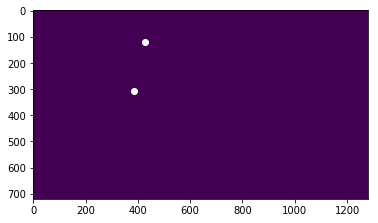

In [55]:
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='zx')
print(T)

[[-3.46272758e+00]
 [-8.76322821e-03]
 [ 1.37152183e+01]]


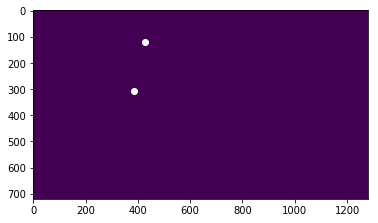

In [56]:
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='xyz')
print(T)

(array([1.54438371]), array([[-3.52359639],
       [-0.01609892],
       [13.8008557 ]]))


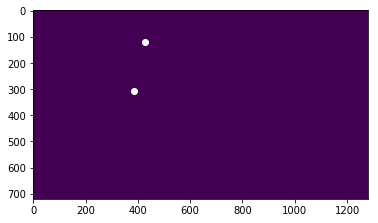

In [62]:
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='xyzyaw')
print(np.rad2deg(np.arccos(R[0,0])), T)

In [ ]:
# ps = np.array([[655, 64]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='zx')
print(T)

[[3.18512870e-03]
 [0.00000000e+00]
 [3.86361895e+01]]


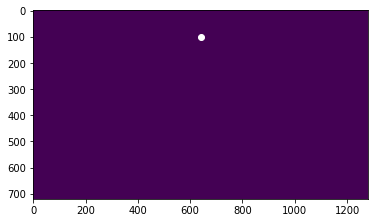

In [406]:
ps = np.array([[642.9, 100]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='zx')
print(T)

[[6.51541428]
 [7.5730734 ]
 [0.        ]]


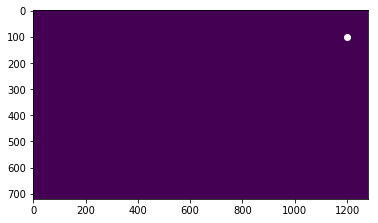

In [407]:
ps = np.array([[1200, 100]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='xy')
print(T)

In [361]:
K

array([[1.02839267e+03, 0.00000000e+00, 6.42907688e+02],
       [0.00000000e+00, 1.03943630e+03, 3.09842219e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

[[-7.45234904e-05]
 [-2.13822661e-05]
 [ 0.00000000e+00]]


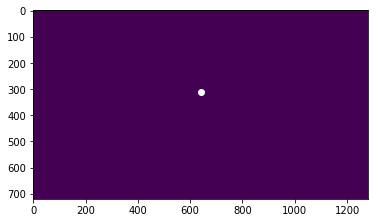

In [362]:
ps = np.array([[642.9, 309.84]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='xy')
print(T)

[[-0.02806223]
 [-2.05606811]
 [ 0.        ]]


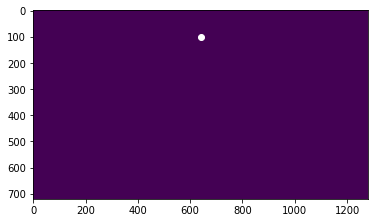

In [348]:
ps = np.array([[640, 100]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
R, T = localize(ps, Pws, K, dist, method='xy')
print(T)

[[ 0.00465529]
 [-1.65891564]]


(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[0.00465529, 0.        , 0.        ]]))

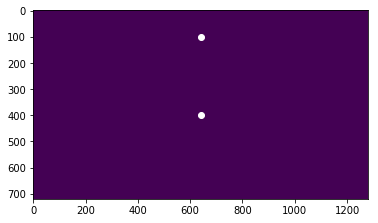

In [262]:
ps = np.array([[640, 100], [640, 400]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
localize(ps, Pws, K, dist, method='x')

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[ 2.18400211e-03],
        [-2.32321014e-01],
        [-4.67005478e+00]]))

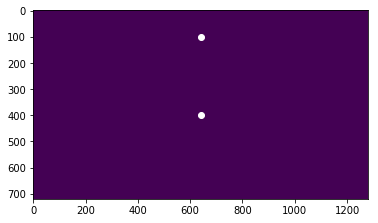

In [253]:
ps = np.array([[640, 400], [640, 100]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
localize(ps, Pws, K, dist)

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[-2.50641153e-03],
        [ 1.07695162e-01],
        [-3.01406899e+00]]))

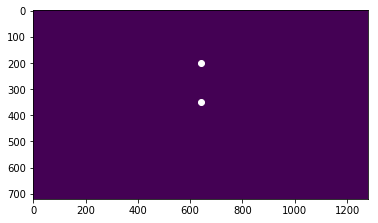

In [254]:
ps = np.array([[640, 200], [640, 350]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
localize(ps, Pws, K, dist)

[[0.]
 [0.]]


(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[0., 0., 0.]]))

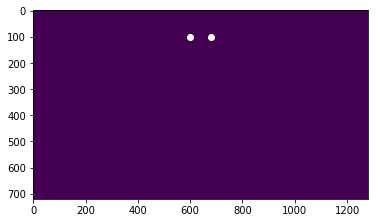

In [255]:
# ps = np.array([[100, 500], [1180, 500]])
ps = np.array([[600, 100], [680, 100]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
localize(ps, Pws, K, dist, method='x')

[[-0.00579221]
 [ 0.04949538]
 [ 2.04949538]]


(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[-0.00579221,  0.        ,  0.        ]]))

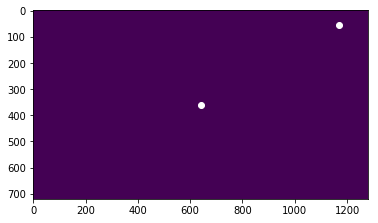

In [256]:
ps = np.array([[640, 360], [1169, 56]])
plt.imshow(np.zeros((720, 1280)))
plt.scatter(ps[:, 0], ps[:, 1], color='white')
localize(ps, Pws, K, dist, method='xy')

In [257]:
A = np.block([np.array([1, 0, 0]).reshape((-1, 1)), np.dot(Kinv, u1)])
A[1, 1] += 1
A

array([[ 1.        , -0.52791867],
       [ 0.        ,  1.07326835],
       [ 0.        ,  1.        ]])

In [258]:
np.array([1, 0, 0]).reshape((1, -1))

array([[1, 0, 0]])

In [259]:
np.dot(Kinv, [601, 386, 1])

array([-0.04075067,  0.07326835,  1.        ])

In [260]:
u = np.hstack([ps_undistort[0], 1]).reshape([-1, 1])
A = np.block([np.array([[1, 0], [0, 1], [0, 0]]), -np.dot(Kinv, u)])
b = - Pws[0].reshape([-1, 1])
b[2, 0] += 1
ans = np.dot(np.linalg.pinv(A), b)[:3]
ans

array([[-0.04244019],
       [-0.20573942],
       [ 1.        ]])

In [249]:
b

array([[-0.],
       [-0.],
       [-0.]])